In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

sys.path.append(os.path.join(os.getcwd(), '../src'))
from metrics import calculate_topk_accuracy
import faissEncoder as faiss_enc
import utils
from logger import setup_custom_logger  

In [2]:
def compare_predictions(results, models):
    def compare_positions(row, df2):
        code = row['code']
        codes1 = row['codes']
        codes2 = df2.at[row.name, 'codes']

        position_df1 = codes1.index(code) if code in codes1 else float('inf')
        position_df2 = codes2.index(code) if code in codes2 else float('inf')

        return position_df1, position_df2
    N = len(models)
    comparison_matrix = np.zeros((N, N), dtype=int)

    for (i, j) in combinations(range(N), 2):
        df1, df2 = results[i], results[j]

        positions = df1.apply(compare_positions, df2=df2, axis=1)
        model1_earlier_count = np.sum(positions.apply(lambda x: x[0] < x[1]))
        model2_earlier_count = np.sum(positions.apply(lambda x: x[1] < x[0]))

        comparison_matrix[i, j] = model1_earlier_count
        comparison_matrix[j, i] = model2_earlier_count

    return pd.DataFrame(comparison_matrix, index=models, columns=models)

def plot_heatmap(comparisons_df, corpus):
    """
    This function generates and saves a heatmap based on the given DataFrame.
    
    Parameters:
    comparisons_df (pd.DataFrame): DataFrame with the data for the heatmap.
    corpus (str): Name of the corpus for naming the saved file.
    """
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(comparisons_df, annot=True, fmt='d', cmap='coolwarm', cbar=True)
    
    plt.title('Cleaned gold standard comparison', fontsize=12, fontweight='bold')
    
    plt.xlabel('')
    plt.ylabel('')
    
    plt.xticks(rotation=0, ha='center')
    plt.yticks(rotation=0)
    
    plt.savefig(f'../pdf/{corpus}_cleaned_gold_standard_comparison.pdf', bbox_inches='tight')
    plt.show()

In [3]:
CORPUS = "DisTEMIST"
models = []
results = []
F_TYPE = "FlatIP"
MAX_LENGTH = 256
TOP_N = 2
TOP_K_VALUES = [1,5,25,50,100,200]

In [4]:
test_df, train_df, gaz_df = utils.load_corpus_data(CORPUS)
link_gaz_df = pd.concat([train_df[['code', 'term']], gaz_df[['code', 'term']]], ignore_index=True) 
no_code_count = test_df['code'].str.contains('NO_CODE').sum()
composite_count = test_df['code'].str.contains(r'\+').sum()
print(f"Number of NO_CODE: {no_code_count}")
print(f"Number of composite(+): {composite_count}")
test_df = test_df[~test_df['code'].str.contains('NO_CODE|\+', regex=True)]

Number of NO_CODE: 0
Number of composite(+): 91


In [5]:
gaz_df.head()

,code,language,term,semantic_tag,mainterm
0,9989000,es,anomalía congénita de dedo del pie,disorder,1
1,9989000,es,malformación congénita de dedo del pie,disorder,0
2,9984005,es,exfoliación de dientes por enfermedad sistémica,disorder,1
3,9982009,es,intoxicación causada por cocaína,disorder,1
4,998008,es,enfermedad de Chagas con compromiso del corazón,disorder,1


In [6]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_grandparents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_granparent_preds = test_df.copy()
clinlinker_granparent_preds["candidates"] = candidates
clinlinker_granparent_preds["codes"] = codes
models.append("ClinLinker-KB-GP")
results.append(clinlinker_granparent_preds)
del faiss_encoder

/home/fernandogd/.conda/envs/kg_env/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Encoding:   0%|          | 0/4716 [00:00<?, ?it/s]

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_parents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_parent_preds = test_df.copy()
clinlinker_parent_preds["candidates"] = candidates
clinlinker_parent_preds["codes"] = codes
models.append("ClinLinker-KB-P")
results.append(clinlinker_parent_preds)
del faiss_encoder

Encoding:   0%|          | 0/4716 [00:00<?, ?it/s]

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
faiss_encoder = faiss_enc.FaissEncoder("../../../models/NEL/spanish_sapbert_models/sapbert_15_noparents_1epoch", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
clinlinker_preds = test_df.copy()
clinlinker_preds["candidates"] = candidates
clinlinker_preds["codes"] = codes
models.append("ClinLinker")
results.append(clinlinker_preds)
del faiss_encoder

Encoding:   0%|          | 0/4716 [00:00<?, ?it/s]

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
faiss_encoder = faiss_enc.FaissEncoder("cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR-large", F_TYPE, MAX_LENGTH, link_gaz_df)
faiss_encoder.fitFaiss()
candidates, codes, _ = faiss_encoder.getCandidates(test_df["term"].tolist(), k=200)
baseline_preds = test_df.copy()
baseline_preds["candidates"] = candidates
baseline_preds["codes"] = codes
models.append("SapBERT-XLM-R-large")
results.append(baseline_preds)
del faiss_encoder

/home/fernandogd/.conda/envs/kg_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Encoding:   0%|          | 0/4716 [00:00<?, ?it/s]

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
comparisons_df = compare_predictions(results, models)
comparisons_df.head()

,ClinLinker-KB-GP,ClinLinker-KB-P,ClinLinker,SapBERT-XLM-R-large
ClinLinker-KB-GP,0,373,444,488
ClinLinker-KB-P,319,0,396,457
ClinLinker,326,337,0,415
SapBERT-XLM-R-large,379,395,373,0


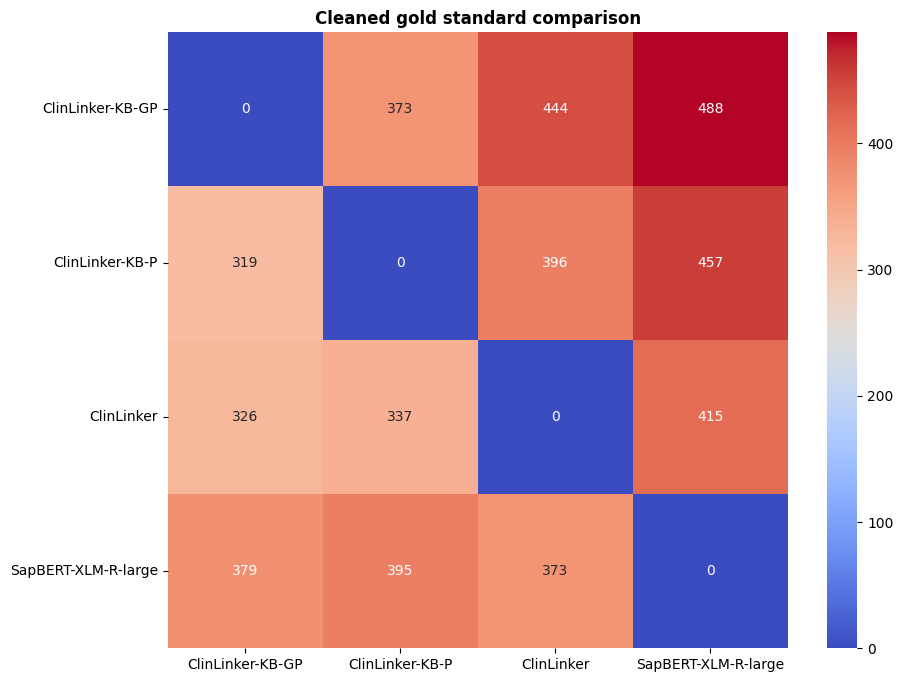

In [11]:
plot_heatmap(comparisons_df, CORPUS)
